In [1]:
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


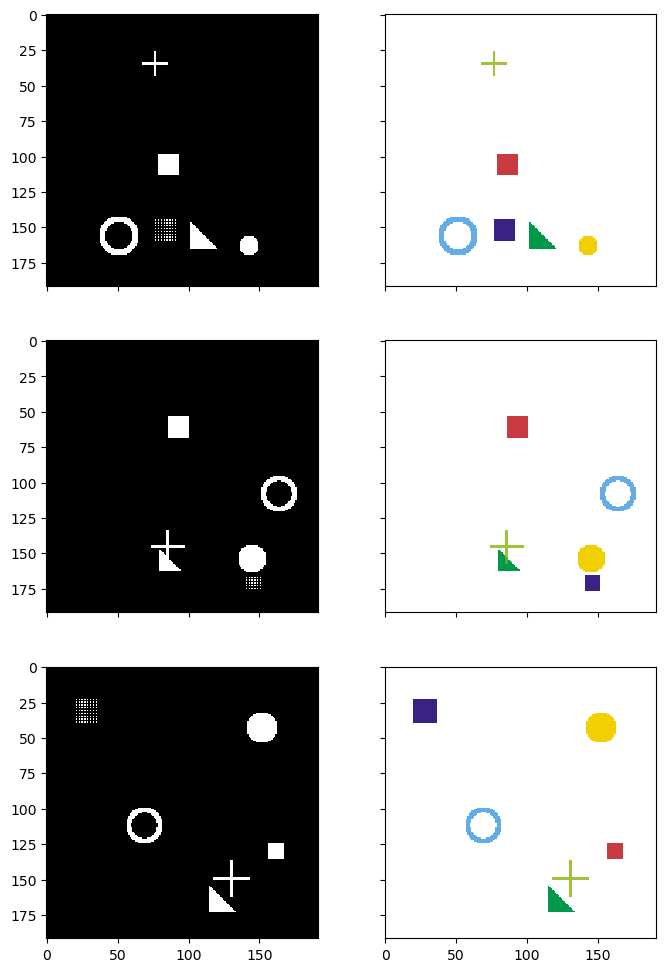

In [2]:
###########################################
# 데이터 생성 테스트
###########################################
import helpers
import simulation

input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

input_images_rgb = [x.astype(np.uint8) for x in input_images]
target_masks_rgb = [helpers.masks_to_colorimg(x) for x in target_masks]
helpers.plot_side_by_side([input_images_rgb, target_masks_rgb])
plt.show()

In [ ]:
###########################################
# 데이터 로더 생성
###########################################
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

# 전처리(numpy to tensor)
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(500, transform = trans)
val_set = SimDataset(20, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 8

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

In [3]:
###########################################
# 모델 학습 함수
###########################################
from collections import defaultdict
import torch.nn.functional as F
import copy
import time

def loss_function(pred, target, smooth = 1.):
    
    ## to-do


    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = loss_function(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
###########################################
# main
###########################################
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import model_sample

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = model_sample.UNet(num_class).to(device)

optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)


cuda:0
Epoch 0/9
----------
LR 0.0001
train: bce: 0.229648, dice: 0.994653, loss: 0.612151
val: bce: 0.036315, dice: 0.993373, loss: 0.514844
saving best model
0m 14s
Epoch 1/9
----------
LR 0.0001
train: bce: 0.023927, dice: 0.878995, loss: 0.451461
val: bce: 0.018764, dice: 0.771623, loss: 0.395194
saving best model
0m 14s
Epoch 2/9
----------
LR 0.0001
train: bce: 0.021820, dice: 0.707895, loss: 0.364857
val: bce: 0.023288, dice: 0.610002, loss: 0.316645
saving best model
0m 14s
Epoch 3/9
----------
LR 0.0001
train: bce: 0.019972, dice: 0.488250, loss: 0.254111
val: bce: 0.019010, dice: 0.409227, loss: 0.214118
saving best model
0m 14s
Epoch 4/9
----------
LR 0.0001
train: bce: 0.016943, dice: 0.396470, loss: 0.206707
val: bce: 0.018374, dice: 0.391803, loss: 0.205088
saving best model
0m 14s
Epoch 5/9
----------
LR 0.0001
train: bce: 0.015416, dice: 0.362342, loss: 0.188879
val: bce: 0.015823, dice: 0.342456, loss: 0.179139
saving best model
0m 14s
Epoch 6/9
----------
LR 0.0001
tr

(3, 6, 192, 192)


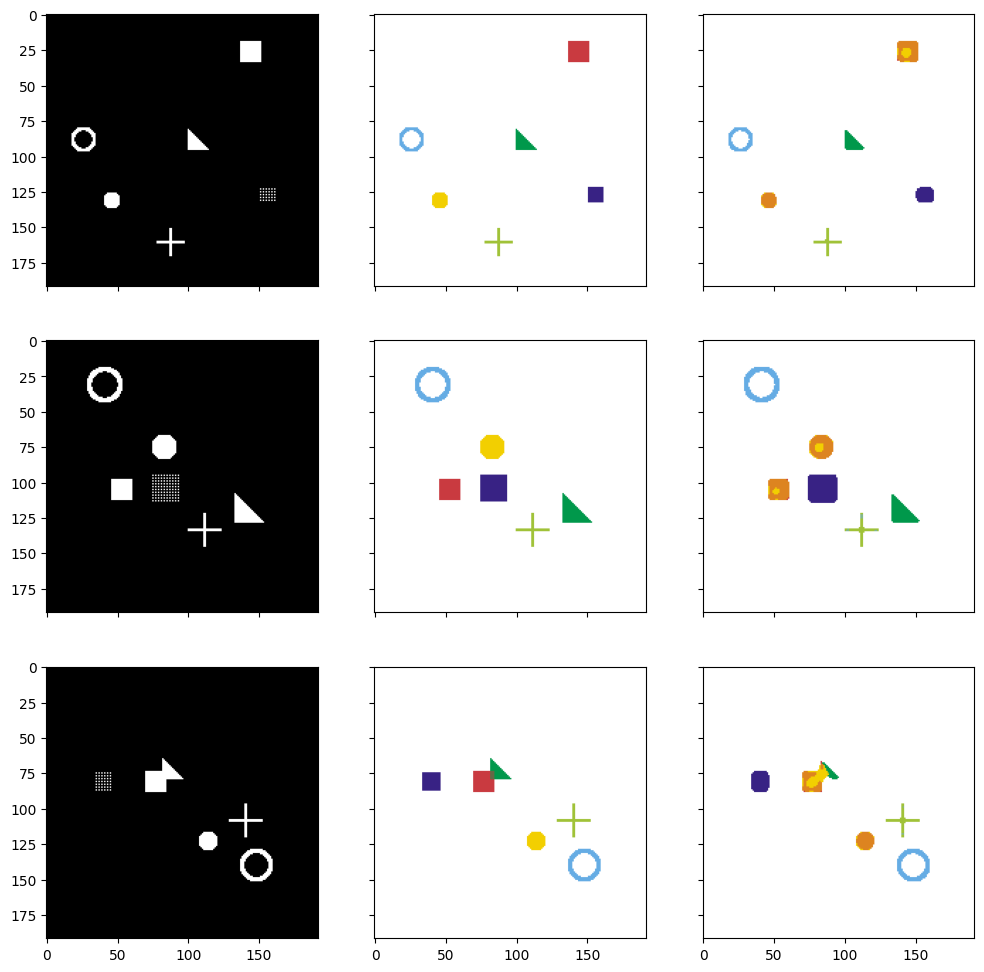

In [16]:
###########################################
# prediction
###########################################
import math

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helpers.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helpers.masks_to_colorimg(x) for x in pred]

helpers.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])